# CIFAR10 Classifier : TensorFlow 2.x

This notebook performs CIFAR10 classification on **TPU** 🏋🏽‍♀️ using:
- Resnet 50 as backbone
- Tensorflow Datasets
- Large batch sizes

---
@Date: 11-Sep-2020 | @Author: Katnoria

In [1]:
# Install the latest version of tensorflow & tensorflow datasets
!pip install -q tfds-nightly tensorflow

     |████████████████████████████████| 3.5MB 3.4MB/s 


In [2]:
import os
import time
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Model
# For GCS (you will need this to store dataset and model checkpoints)
from google.colab import auth
auth.authenticate_user()

In [3]:
def version_info(cls):
    print(f"{cls.__name__}: {cls.__version__}")

In [4]:
print("Version Used in this Notebook:")
version_info(tf)
version_info(tfds)

Version Used in this Notebook:
tensorflow: 2.3.0
tensorflow_datasets: 3.2.1


## TPU Initialization
Initialize the the TPU and make use of distribution strategy

In [5]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.35.89.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.35.89.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')]


In [6]:
# Use the abstraction to run models on CPU, GPUs or TPUs. see https://www.tensorflow.org/guide/distributed_training
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# Dataset

Tensorflow Datasets already provides this dataset in a format that we can use out of the box.

In [7]:
# We will store the dataset and model checkpoints on the GCS
GCS_DATA_DIR = "gs://gtdemo-fd57b.appspot.com"

## Download Dataset

In [8]:
# Load the dataset
(ds_train, ds_test), metadata = tfds.load(
    'cifar10', split=['train', 'test'], shuffle_files=True, 
    with_info=True, as_supervised=True, try_gcs=True,
    data_dir=GCS_DATA_DIR
)

In [9]:
# Review metadata
# See https://www.tensorflow.org/datasets/overview
metadata

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

In [10]:
NUM_CLASSES = metadata.features["label"].num_classes

num_train_examples = metadata.splits['train']
num_test_examples = metadata.splits['test']
print(f"Training dataset size: {num_train_examples}")
print(f"Test dataset size: {num_test_examples}")

Training dataset size: <tfds.core.SplitInfo num_examples=50000>
Test dataset size: <tfds.core.SplitInfo num_examples=10000>


## Load Dataset

We want to make sure that we take full advantage of 8 TPU Cores and their individual systolic arrays. 
According to this [post](https://blog.tensorflow.org/2019/01/keras-on-tpus-in-colab.html), the systolic arrays are 128 x 128 and we should use 128 * number of cores.

In [11]:
# Params
IMG_SIZE = 32
BATCH_SIZE = 128 * strategy.num_replicas_in_sync

We need to cast for float32, TPU does not like uint8 (which is the default type of images in our dataset)

In [12]:
def cast_to_float32(image, label):
  return tf.cast(image, tf.float32), label


Next, we split the dataset into training and test, shuffle -> batch -> prefetch.

In [13]:
train_ds = ds_train \
    .map(cast_to_float32) \
    .shuffle(10000).batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

Let's visualize an example from the dataset

In [16]:
examples = train_ds.take(100)

[]

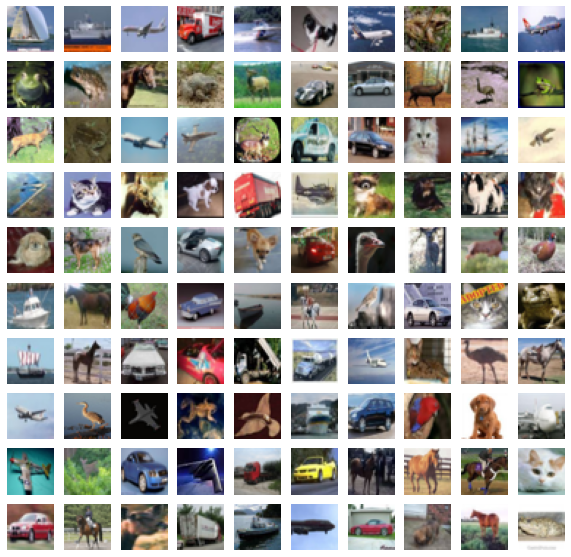

In [17]:
fig, axs = plt.subplots(10, 10, figsize=(10,10))
for idx, ax in enumerate(axs.flat):
  img = tf.cast(images[idx], tf.uint8)
  ax.imshow(img)
  ax.axis("off")
plt.plot()  

Create the test set

In [18]:
test_ds = ds_test \
    .map(cast_to_float32) \
    .batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

Add a utility function to plot the accuracy and loss

In [19]:
def plot_history(history):
    plt.style.use('seaborn')
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))    

    ax1.plot(acc, label="Training Accuracy")
    ax1.plot(val_acc, label="Validation Accuracy")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')    
    ax1.legend(loc='lower right')
    ax1.set_title("Training and Validation Accuracy")
    
    loss = history.history['loss']
    val_loss = history.history['val_sparse_categorical_accuracy']
    ax2.plot(loss, label="Training Loss")
    ax2.plot(val_loss, label="Validation Loss")
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')    
    ax2.legend(loc='upper right')
    ax2.set_title("Training and Validation Loss")
    
    plt.show()

# Build Model


Instead of training the full model, it is generally a good practice to use a pretrained network as a base model and add your layers on top. 

This allows leverage on what base model has learned, reduce the training times and cost.

In [20]:
transforms = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
def get_pretrained_model(base_model, preprocess_input, transforms=None):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    if transforms is not None:
        x = transforms(inputs)
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES)(x)
    _model = tf.keras.Model(inputs, outputs)    
    return _model

Add the model training callbacks. We will use model checkpoint and reduce lr 

In [22]:
# Callbacks

# Reduce LR
lr = 1e-3
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

# Model Checkpoint
ckptr = tf.keras.callbacks.ModelCheckpoint(    
    f"{GCS_DATA_DIR}/tf2_resnet_tpu_model.h5", save_best_only=True,
    )


# Tensorboard
# logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_cb = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

We need to make sure that the model is created and compiled under the strategy scope.

In [23]:
with strategy.scope():
  base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
  base_model.trainable = False  
  model = get_pretrained_model(base_model, tf.keras.applications.resnet.preprocess_input)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(lr),
      # experimental_steps_per_execution = 50,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['sparse_categorical_accuracy'],      
  )

94773248/94765736 [==============================] - 1s 0us/step


In [24]:
# Let's see the eval accuracy before we train the model
model.evaluate(test_ds, return_dict=True)

1/9 [==>...........................] - ETA: 18s - loss: 6.3432 - sparse_categorical_accuracy: 0.0869WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0052s vs `on_test_batch_end` time: 0.0194s). Check your callbacks.


9/9 [==============================] - 3s 287ms/step - loss: 6.2554 - sparse_categorical_accuracy: 0.0858


{'loss': 6.255364894866943, 'sparse_categorical_accuracy': 0.085828997194767}

# Train

We are now ready to train our model.

In [25]:
EPOCHS=50

# track training time
training_start = time.time()

# train the model
history = model.fit(
    train_ds, epochs=EPOCHS, validation_data=test_ds, verbose=2, 
    callbacks=[reduce_lr_cb, ckptr]
)

# print training time
total_time = time.time() - training_start
print(f"Total training time {total_time//60 :.0f}m {total_time%60:.0f}s")

Epoch 1/50


48/48 - 4s - loss: 3.0550 - sparse_categorical_accuracy: 0.4056 - val_loss: 1.5704 - val_sparse_categorical_accuracy: 0.5729
Epoch 2/50
48/48 - 4s - loss: 1.8190 - sparse_categorical_accuracy: 0.5388 - val_loss: 1.2624 - val_sparse_categorical_accuracy: 0.6177
Epoch 3/50
48/48 - 4s - loss: 1.4649 - sparse_categorical_accuracy: 0.5751 - val_loss: 1.1433 - val_sparse_categorical_accuracy: 0.6349
Epoch 4/50
48/48 - 4s - loss: 1.2590 - sparse_categorical_accuracy: 0.6056 - val_loss: 1.0658 - val_sparse_categorical_accuracy: 0.6465
Epoch 5/50
48/48 - 4s - loss: 1.1443 - sparse_categorical_accuracy: 0.6248 - val_loss: 1.0273 - val_sparse_categorical_accuracy: 0.6544
Epoch 6/50
48/48 - 4s - loss: 1.0737 - sparse_categorical_accuracy: 0.6397 - val_loss: 1.0041 - val_sparse_categorical_accuracy: 0.6557
Epoch 7/50
48/48 - 5s - loss: 1.0273 - sparse_categorical_accuracy: 0.6495 - val_loss: 0.9945 - val_sparse_categorical_accuracy: 0.6637
Epoch 8/50
48/48 - 4s - loss: 1.0018 - sparse_categorical_a

We can now plot the training accuracy and loss. You'll notice that we have used the test split as our validation dataset. What you want to do is this:
- Split training data into train and validation set
- Use test data for the final evaluation

We have done that in the GPU version of the notebook [here](http)

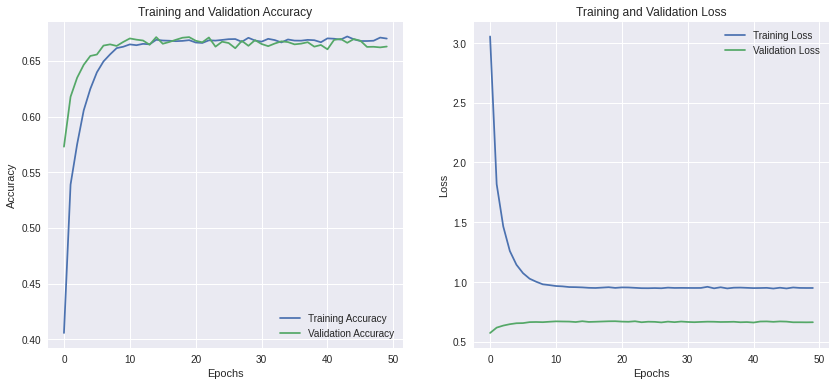

In [26]:
# We can now plot 
plot_history(history)

## Another Model

In this example, we increase the number of dense layers and add dropout

In [27]:
def get_pretrained_model_v2(base_model, transforms=None):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    if transforms is not None:
        x = transforms(inputs)
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)        
    x = Dropout(0.7)(x)
    outputs = Dense(NUM_CLASSES)(x)
    _model = tf.keras.Model(inputs, outputs)    
    return _model

# Callbacks

# Reduce LR
lr = 1e-3
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

# Model Checkpoint
ckptr = tf.keras.callbacks.ModelCheckpoint(    
    f"{GCS_DATA_DIR}/tf2_resnet_tpu_model_v2.h5", save_best_only=True,
    )

In [28]:
with strategy.scope():
  base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
  base_model.trainable = False  
  model = get_pretrained_model_v2(base_model, tf.keras.applications.resnet.preprocess_input)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(lr),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['sparse_categorical_accuracy'],      
  )

In [29]:
EPOCHS=50

# track training time
training_start = time.time()

# train the model
history = model.fit(
    train_ds, epochs=EPOCHS, validation_data=test_ds, verbose=2, 
    callbacks=[reduce_lr_cb, ckptr]
)

# print training time
total_time = time.time() - training_start
print(f"Total training time {total_time//60 :.0f}m {total_time%60:.0f}s")

Epoch 1/50


48/48 - 8s - loss: 2.1882 - sparse_categorical_accuracy: 0.3874 - val_loss: 1.2296 - val_sparse_categorical_accuracy: 0.5738
Epoch 2/50
48/48 - 4s - loss: 1.4223 - sparse_categorical_accuracy: 0.5124 - val_loss: 1.1152 - val_sparse_categorical_accuracy: 0.6089
Epoch 3/50
48/48 - 4s - loss: 1.3047 - sparse_categorical_accuracy: 0.5515 - val_loss: 1.0681 - val_sparse_categorical_accuracy: 0.6257
Epoch 4/50
48/48 - 4s - loss: 1.2247 - sparse_categorical_accuracy: 0.5748 - val_loss: 1.0316 - val_sparse_categorical_accuracy: 0.6388
Epoch 5/50
48/48 - 4s - loss: 1.1691 - sparse_categorical_accuracy: 0.5943 - val_loss: 1.0161 - val_sparse_categorical_accuracy: 0.6431
Epoch 6/50
48/48 - 4s - loss: 1.1254 - sparse_categorical_accuracy: 0.6054 - val_loss: 0.9980 - val_sparse_categorical_accuracy: 0.6484
Epoch 7/50
48/48 - 4s - loss: 1.0910 - sparse_categorical_accuracy: 0.6192 - val_loss: 0.9790 - val_sparse_categorical_accuracy: 0.6577
Epoch 8/50
48/48 - 4s - loss: 1.0632 - sparse_categorical_a

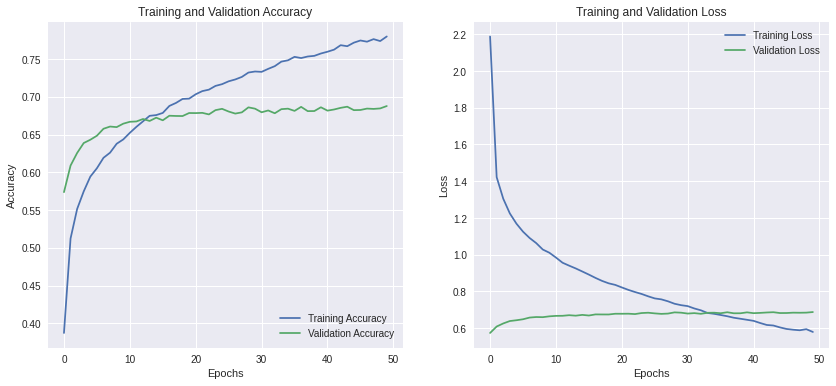

In [30]:
plot_history(history)

# Next Steps

This is a very simple example of training CIFAR10 classifier using a pre-trained network. Its your turn to turn the knobs 🎛 and see if you can get model to generalise better. Some ideas:

* make the model overfit your training data
* regularize the model to generalize better
* increase/decrease model capacity based on what you find in above steps
* add image augmentation
* use hyperparameter tuning library to find the best set of combination
* rollout your own model from scratch, you can use the tuning library to help design the network too.